In [1]:
# Following tutorial at https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/
# import the necessary packages
from imutils.video import VideoStream
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import h5py
birdclassifier = models.load_model("bird_classifier.h5")

In [8]:
def imageframelabel(frame, shape, image, label, file, i):
    (x,y,w,h) = shape
    if label != None:
        #draw rectangle around image area.
        cv2.rectangle(frame, (x,y), (x + h, y + h), (220,220,220), 2)
        #Draw add text to image area - mostly for testing.
        if (x-5>0):
            cv2.putText(frame,  "Species: {}".format(label), (x-5, y-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,0), 2)
        else:
            cv2.putText(frame,  "Species: {}".format(label), (x+h+5, y-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,0), 2)
        #####Unhash to save each hummingbird photo in a classified directory.
        #where_to_save = 'Pictures/Hummingbirds/images/' + label + '/'
        #if not (os.path.exists(where_to_save)):
        #    os.mkdir(where_to_save)
        #newfile = where_to_save + file  + str(i) +'.png'
        #cv2.imwrite(newfile, image)
        
def imagecrop(shape,frame):
    (x,y,w,h) = shape
    image = frame[y:y+h,x:x+h] 
    image = cv2.resize(image, (224,224))
    return(image)
        
def predictbird(image):
    test_image = image.reshape((1,)+image.shape)
    test_image = ImageDataGenerator(rescale=1./255,).flow(test_image,
                                                          batch_size=1)
    pred = birdclassifier.predict_generator(test_image)
    #print(pred)
    result = np.argmax(pred, axis=1)
    return(result)

def labelbird(result):
    #Review the result for classification.
    if (result == 2):
        label = None 
    elif (result == 0):
        label = "Broadtailed female"
    elif (result == 1):
        label = "Broadtailed male"
    elif (result == 3):
        label = "Rufous female"
    else:
        label = None
    return(label)



def findmotion(baseframe, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)
        if baseframe is None:                
            baseframe = gray
            plt.imshow(baseframe)
            plt.show() 
        frameDelta = cv2.absdiff(baseframe, gray)
        thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), 
                            cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)  
        cnts = imutils.grab_contours(cnts)
        cv2.imshow("Thresh", thresh)
        cv2.imshow("Frame Delta", frameDelta)        
        cv2.imshow('frame', gray)
        return(cnts,baseframe,gray)

def imagebounds(c,framesize):
    (width,height)=framesize
    if cv2.contourArea(c) > width*height/750:
        expand = 20
        (x, y, w, h) = cv2.boundingRect(c)
        x2 = max(0, x-expand)
        y2 = max(0,y-expand)
        w2 = min(width-x2,w+2*expand)
        h2 = min(height-y2,max(w2,h+2*expand))
    else:
        (x2, y2, w2, h2) =(0,0,5,5)
    return(x2, y2, w2, h2)   



Opening file Pictures/Hummingbirds/New_Videos/06100254.AVI
506


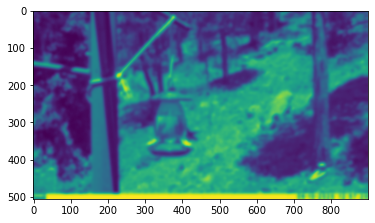

834 Images complete.
Can't receive frame (stream end?). Exiting ...
desktop.ini
holding
holding2
Needs Reviewed
Newvideos
options for display
1 Files complete.


In [12]:
#Existing path to the directory of videos (live stream is a future project)
import os
directory = "Pictures/Hummingbirds/New_Videos" #os.getcwd()
j=0 #Iterator for # of videos.

#Loop through each video in the directory
for filename in os.listdir(directory):
    if not filename.lower().endswith((".avi")):
        print (filename)
        continue
    file=os.path.splitext(filename)[0]
    video = directory +'/'+ filename
    print("Opening file {}".format(video))
    cap = cv2.VideoCapture(video)
    if not cap.isOpened():
        print( "Could not open the input video: " + video)
        break
        
    videodir = directory + '/Newvideos/'
    if not (os.path.exists(videodir)):
        os.mkdir(videodir)
    width = 900
    capwidth = int(cap.get(3))
    height = int(cap.get(4)*width/capwidth)
    print(height)
    out = cv2.VideoWriter(videodir + filename, 
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          10, (width,height))
    out2 = cv2.VideoWriter(videodir + "thresh" +filename, 
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          10, (width,height), False)

#Using the first frame: future video background, i is image count,
#initialize result and a iterator (for status),j is iterated for video count.
    firstFrame = None
    i=0
    result = 2
    a=0
    j=+1
    while(True):
# Capture frame-by-frame
        ret, frame = cap.read()
        
# if frame is read correctly ret is True
        if not ret:
            print(i, "Images complete.")
            print("Can't receive frame (stream end?). Exiting ...")
            break
        frame = imutils.resize(frame, width=width)
        height, width, layers=frame.shape
        size = (width,height)
        cnts,firstFrame, thresh= findmotion(firstFrame, frame)
        #Check to see if there is/was no bird on each frame.
        if(a == 0):
            text = 'No_bird'
        else:
            a =-1 
# loop over the contours.

        for c in cnts:
            shape = imagebounds(c,size)
            (x,y,w,h) = shape
            
            #This just decreases the bits sent to the model to review.
            if(h>width/30):
                i+=1
                #cv2.rectangle(frame, (x, y), (x + h, y + h), 
                #                (220,220,0), 2) #Unhash this to see what the model sees.
                crop_img = imagecrop(shape,frame)
                result = predictbird(crop_img)
                imagetext = labelbird(result)
                imageframelabel(frame, shape, crop_img, imagetext,
                                file, i)
                
            
                
    #Check to see if there is a bird on each frame (all contours).
                if(result != 2):
                    text = 'Hummingbird'
                    a=+1

                    
                    
        cv2.putText(frame, "Feeder Status: {}".format(text), (10,20),
            cv2.FONT_HERSHEY_SIMPLEX, .7, (255,0,0), 2)
        cv2.putText(frame, "File: {}".format(file), (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX, .7, (255,0,0), 2)


# show the frame.
        cv2.imshow("Hummingbird 1", frame)
        out2.write(thresh)
        out.write(frame)

        if cv2.waitKey(1) == ord('q'):
            break
print(j, "Files complete.")
cap.release()
out2.release()
out.release()
cv2.destroyAllWindows()